In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [4]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [6]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")


In [7]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [8]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['station', 'measurement']

In [9]:
# Assign the measurement class to a variable called `Measurement` and
# Assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [80]:
# Find the most recent date in the data set.
most_recent_date_result = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Extract the date from the result
most_recent_date = most_recent_date_result[0]

print(most_recent_date)

2017-08-23


2017-08-23 00:00:00
2016-08-23
            Date  Precipitation
0     2016-08-23            0.0
1009  2016-08-23            NaN
1529  2016-08-23           45.5
704   2016-08-23            1.3
361   2016-08-23            3.8
...          ...            ...
1527  2017-08-22            0.0
1008  2017-08-23            0.0
360   2017-08-23            0.0
1528  2017-08-23            2.0
2229  2017-08-23           11.4

[2230 rows x 2 columns]


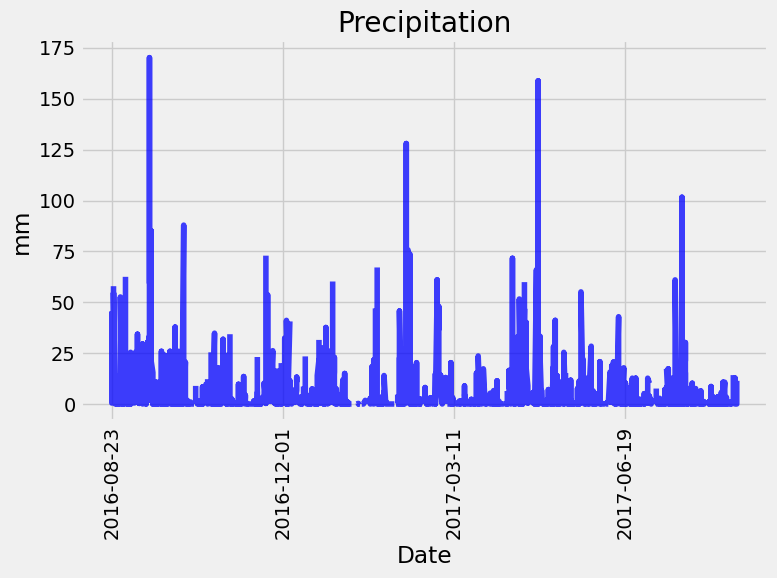

In [81]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.
# In order to apply timedelta(), you need to convert your string to a datetime. One way to do it would be to use strptime():
most_recent_date_dt = (dt.strptime(most_recent_date, '%Y-%m-%d'))
print(most_recent_date_dt)
date_one_year_ago = (most_recent_date_dt - timedelta(days=365)).date()
print(date_one_year_ago)

#Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_one_year_ago).\
filter(Measurement.date <= most_recent_date_dt).all()
precipitation_scores


# # Define the column names
column_names = ['Date', 'Precipitation']

# # Create the DataFrame and set the column names
precipitation_data_df = pd.DataFrame(precipitation_scores, columns = column_names)

# # Display the DataFrame
precipitation_data_df

# # Sort the dataframe by date
precipitation_data_sorted_df = precipitation_data_df.sort_values(by='Date')

# # Display the sorted DataFrame
print(precipitation_data_sorted_df)

# # Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(8, 6))
plt.plot(precipitation_data_sorted_df['Date'], precipitation_data_sorted_df['Precipitation'], marker='', linestyle='-', color='b',alpha=0.75,)

# # Set the title and labels
plt.title('Precipitation')
plt.xlabel('Date')
plt.ylabel('mm')

# Limits to 5 ticks
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))  

# # Rotate date labels for better readability
plt.xticks(rotation= 'vertical')

# Show the plot
plt.tight_layout()
plt.grid(True)
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_data_sorted_df['Precipitation'].describe()
summary_stats

count    2021.000000
mean        4.505888
std        11.713487
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
total_stations

[(9,)]

In [25]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_station = session.query(
    Measurement.station,
    func.count(Measurement.id).label('row_count')
).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()

print(most_active_station)

most_active_station_id = most_active_station[0].station
print(most_active_station_id)


[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]
USC00519281


In [79]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_info = session.query(
    func.min(Measurement.tobs).label('min_temperature'),
    func.max(Measurement.tobs).label('max_temperature'),
    func.avg(Measurement.tobs).label('avg_temperature')
).filter(Measurement.station == most_active_station_id).one()

# Temperature info
min_temperature = temperature_info.min_temperature
max_temperature = temperature_info.max_temperature
avg_temperature = temperature_info.avg_temperature

print(f"Lowest Temperature: {min_temperature}")
print(f"Highest Temperature: {max_temperature}")
print(f"Average Temperature: {avg_temperature}")


Lowest Temperature: 12.2
Highest Temperature: 29.4
Average Temperature: 22.03582251082252


2016-08-23
           Date  Temperature
0    2016-08-23         25.0
1    2016-08-24         25.0
2    2016-08-25         26.7
3    2016-08-26         26.7
4    2016-08-27         23.9
..          ...          ...
347  2017-08-14         25.0
348  2017-08-15         25.0
349  2017-08-16         24.4
350  2017-08-17         24.4
351  2017-08-18         26.1

[352 rows x 2 columns]


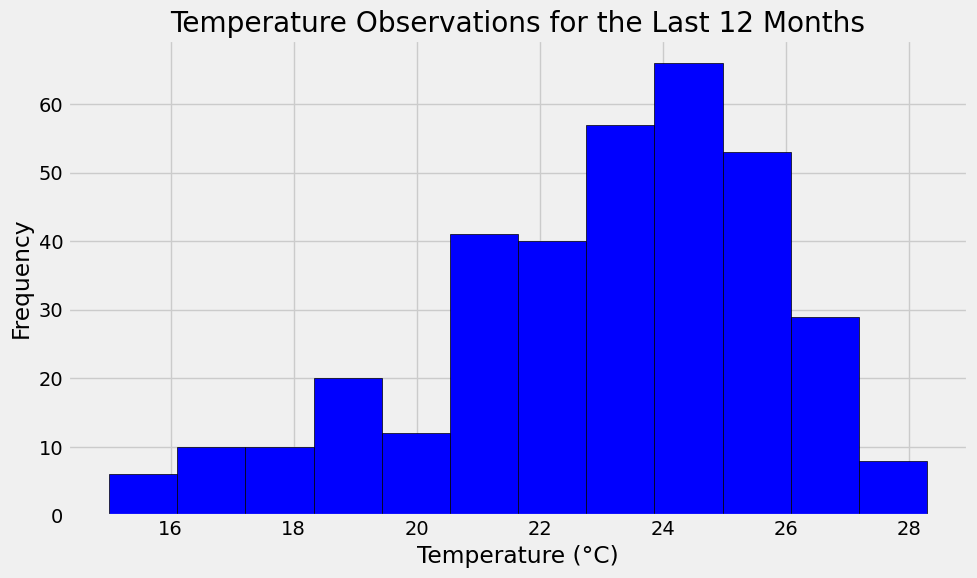

In [78]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Use 12 months from last date in the data
twelve_months_ago = (most_recent_date_dt- timedelta(days=365)).date()
print (twelve_months_ago)

# Query to get the last 12 months of temperature data for the most active station
temperature_data = session.query(
    Measurement.date,
    Measurement.tobs
).filter(
    Measurement.station == most_active_station_id).filter(Measurement.date >= twelve_months_ago
).all()

temperature_data


# # Convert the query results to a DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

# # Display the DataFrame
print(temperature_df)

# Plot the data as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_df['Temperature'], bins=12, color='blue', edgecolor='black')

# # Set the title and labels
plt.title('Temperature Observations for the Last 12 Months')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')

# # Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


# Close Session

In [77]:
# Close Session
session.close()
